In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# seaborn is optional
try:
    import seaborn as sns
    sns.set(style="whitegrid")
    HAS_SEABORN = True
except Exception:
    HAS_SEABORN = False

# SciPy (optional). If missing, use NumPy fallbacks.
try:
    import scipy
    from scipy import stats
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

rng = np.random.default_rng(42)

print("Libraries:", {
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "seaborn": ("installed" if HAS_SEABORN else "not installed"),
    "scipy": (scipy.__version__ if SCIPY_OK else "not installed")
})

CSV_PATH = "/mnt/data/Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv"
print("Dataset path:", CSV_PATH)


Libraries: {'pandas': '2.2.2', 'numpy': '1.26.4', 'seaborn': 'installed', 'scipy': '1.16.2'}
Dataset path: /mnt/data/Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv


In [8]:
import pathlib

SRC = "Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv"
DST = "Airplane_Crashes_clean_utf8.csv"

tried = []
converted = False
for enc in ("cp1252", "latin1"):
    try:
        with open(SRC, "r", encoding=enc) as f:
            text = f.read()
        with open(DST, "w", encoding="utf-8", newline="") as f:
            f.write(text)
        print("Re-encoded file to UTF-8 using:", enc)
        print("Clean file path:", DST)
        converted = True
        break
    except Exception as e:
        tried.append((enc, str(e)))

if not converted:
    print("Failed to re-encode with common single-byte encodings.")
    print("Tried:", tried)



Re-encoded file to UTF-8 using: cp1252
Clean file path: Airplane_Crashes_clean_utf8.csv


In [9]:
import pandas as pd

CSV_PATH = "Airplane_Crashes_clean_utf8.csv"
df = pd.read_csv(CSV_PATH)
print("Loaded dataset successfully after re-encoding.")
print("Shape:", df.shape)
print("Columns (first 10):", list(df.columns)[:10])
print(df.head(3))


Loaded dataset successfully after re-encoding.
Shape: (4998, 17)
Columns (first 10): ['Date', 'Time', 'Location', 'Operator', 'Flight #', 'Route', 'AC Type', 'Registration', 'cn/ln', 'Aboard']
        Date   Time                   Location              Operator Flight #  \
0  9/17/1908  17:18        Fort Myer, Virginia  Military - U.S. Army      NaN   
1   9/7/1909    NaN    Juvisy-sur-Orge, France                   NaN      NaN   
2  7/12/1912   6:30  Atlantic City, New Jersey  Military - U.S. Navy      NaN   

           Route           AC Type Registration cn/ln  Aboard  \
0  Demonstration  Wright Flyer III          NaN     1     2.0   
1       Air show    Wright Byplane          SC1   NaN     1.0   
2    Test flight         Dirigible          NaN   NaN     5.0   

   Aboard Passangers  Aboard Crew  Fatalities  Fatalities Passangers  \
0                1.0          1.0         1.0                    1.0   
1                0.0          1.0         1.0                    0.0   
2    

In [10]:
def find_col(candidates):
    low_map = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in low_map:
            return low_map[cand.lower()]
    return None

COL_DATE     = find_col(["Date"])
COL_TIME     = find_col(["Time"])
COL_LOCATION = find_col(["Location", "Country", "Region"])
COL_ABOARD   = find_col(["Aboard", "Aboard Passengers", "Aboard_Total"])
COL_FATAL    = find_col(["Fatalities", "Fatalities_Total", "Deaths"])
COL_GROUND   = find_col(["Ground"])
COL_NAME     = find_col(["Name", "Incident", "Event"])

print("Column mapping (None = not found):")
print({
    "date": COL_DATE, "time": COL_TIME, "location": COL_LOCATION,
    "aboard": COL_ABOARD, "fatalities": COL_FATAL, "ground": COL_GROUND,
    "name": COL_NAME
})


Column mapping (None = not found):
{'date': 'Date', 'time': 'Time', 'location': 'Location', 'aboard': 'Aboard', 'fatalities': 'Fatalities', 'ground': 'Ground', 'name': None}


In [11]:
# Dates
if COL_DATE is not None:
    df["date_parsed"] = pd.to_datetime(df[COL_DATE], errors="coerce")
    df["year"] = df["date_parsed"].dt.year
    df["decade"] = (df["year"] // 10) * 10
else:
    df["date_parsed"] = pd.NaT
    df["year"] = np.nan
    df["decade"] = np.nan

# Numerics
for c in [COL_ABOARD, COL_FATAL, COL_GROUND]:
    if c is not None:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Survivors and survival rate
if (COL_ABOARD is not None) and (COL_FATAL is not None):
    df["survivors"] = df[COL_ABOARD] - df[COL_FATAL]
    denom = df[COL_ABOARD].replace({0: np.nan})
    df["survival_rate"] = df["survivors"] / denom
else:
    df["survivors"] = np.nan
    df["survival_rate"] = np.nan

print("Parsed dates and converted numeric columns.")
print("NA counts (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))


Parsed dates and converted numeric columns.
NA counts (top 10):
Flight #                 3669
Time                     1512
Route                     777
cn/ln                     668
Registration              274
Fatalities Passangers     242
Fatalities Crew           241
Aboard Passangers         229
Aboard Crew               226
Summary                    64
dtype: int64


In [12]:
before = len(df)
need_cols = []
if "year" in df.columns: need_cols.append("year")
if COL_ABOARD is not None: need_cols.append(COL_ABOARD)
if COL_FATAL  is not None: need_cols.append(COL_FATAL)

df_clean = df.dropna(subset=need_cols) if need_cols else df.copy()
after = len(df_clean)

print("Rows before cleaning:", before)
print("Rows after cleaning:", after)
print("Message:", "We kept rows with required fields for the main analyses.")


Rows before cleaning: 4998
Rows after cleaning: 4980
Message: We kept rows with required fields for the main analyses.


In [13]:
print("Basic counts:")
print({
    "total_rows": int(len(df)),
    "rows_with_year": int(df["year"].notna().sum()) if "year" in df.columns else None,
    "rows_with_aboard_fatal": int((df[COL_ABOARD].notna() & df[COL_FATAL].notna()).sum()) if (COL_ABOARD and COL_FATAL) else None
})

stats_cols = []
if COL_FATAL is not None: stats_cols.append(COL_FATAL)
if "survival_rate" in df.columns: stats_cols.append("survival_rate")

if stats_cols:
    num_desc = df[stats_cols].describe().T
    print("Descriptive statistics (key metrics):")
    print(num_desc[["count","mean","50%","std","min","max"]])
else:
    print("No numeric columns available for descriptive statistics.")


Basic counts:
{'total_rows': 4998, 'rows_with_year': 4998, 'rows_with_aboard_fatal': 4980}
Descriptive statistics (key metrics):
                count       mean   50%        std  min    max
Fatalities     4990.0  22.373547  11.0  35.061741  0.0  583.0
survival_rate  4975.0   0.181489   0.0   0.311724  0.0    1.0


Yearly crashes (head):
   year  crashes
0  1908        1
1  1909        1
2  1912        1
3  1913        3
4  1915        2
5  1916        5
6  1917        7
7  1918        4
8  1919        8
9  1920       18


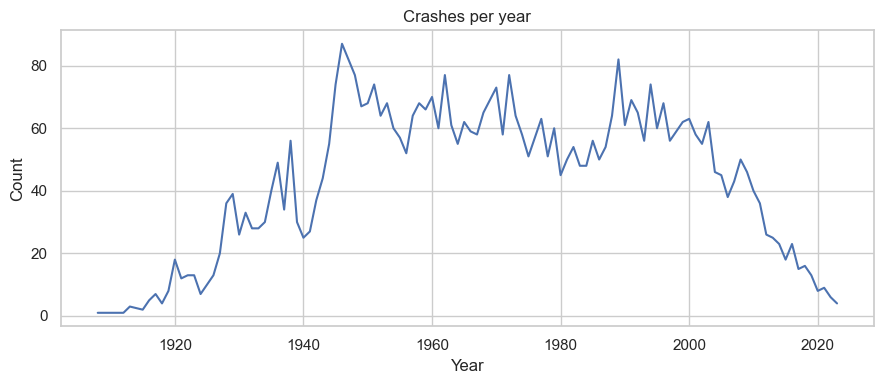

In [14]:
if "year" in df_clean.columns:
    yearly = df_clean.groupby("year").size().reset_index(name="crashes")
    print("Yearly crashes (head):")
    print(yearly.head(10))

    plt.figure(figsize=(9,4))
    plt.plot(yearly["year"], yearly["crashes"])
    plt.title("Crashes per year")
    plt.xlabel("Year"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Year column is not available for time trend.")


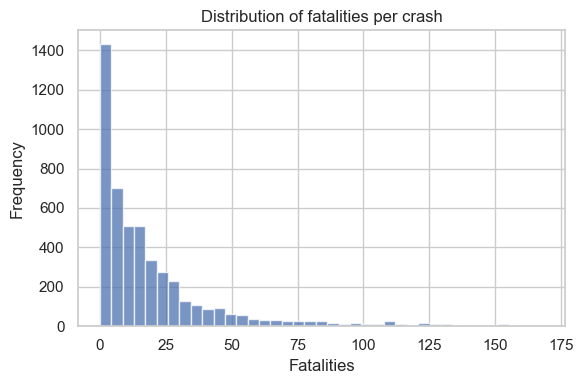

Fatalities stats:
{'mean': 22.40180722891566, 'median': 11.0, 'std': 35.08961637996774}


In [15]:
if COL_FATAL is not None:
    vals = df_clean[COL_FATAL].dropna().values
    if len(vals) > 0:
        plt.figure(figsize=(6,4))
        # Trim extreme tail for visualization
        upper = np.percentile(vals, 99)
        bins = np.linspace(0, upper, 40) if upper > 0 else 20
        plt.hist(vals, bins=bins, alpha=0.75)
        plt.title("Distribution of fatalities per crash")
        plt.xlabel("Fatalities"); plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        print("Fatalities stats:")
        print({"mean": float(np.mean(vals)),
               "median": float(np.median(vals)),
               "std": float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0})
    else:
        print("No fatalities data to summarize.")
else:
    print("Fatalities column not found.")


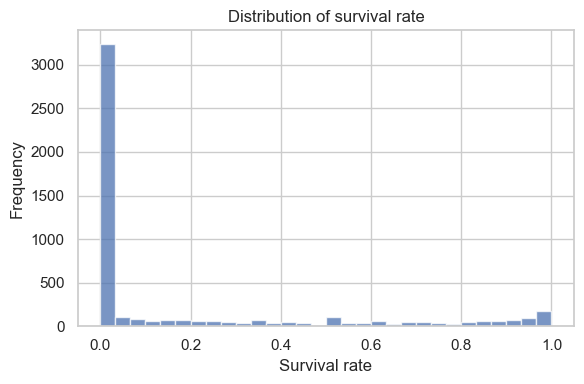

Survival rate stats:
{'mean': 0.181489019431307, 'median': 0.0, 'std': 0.3117242492487997}


In [16]:
if "survival_rate" in df_clean.columns:
    sr = df_clean["survival_rate"].dropna()
    # keep only valid 0..1
    sr = sr[(sr >= 0) & (sr <= 1)]
    if len(sr) > 0:
        plt.figure(figsize=(6,4))
        plt.hist(sr, bins=30, alpha=0.75)
        plt.title("Distribution of survival rate")
        plt.xlabel("Survival rate"); plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

        print("Survival rate stats:")
        print({"mean": float(sr.mean()),
               "median": float(sr.median()),
               "std": float(sr.std(ddof=1)) if len(sr) > 1 else 0.0})
    else:
        print("No survival rate data available.")
else:
    print("Survival rate column not available.")


In [17]:
if ("decade" in df_clean.columns) and (COL_FATAL is not None):
    decade_counts = df_clean["decade"].value_counts().sort_index()
    # choose two decades with most rows
    top_decades = decade_counts.sort_values(ascending=False).head(2).index.tolist()

    if len(top_decades) == 2:
        d1, d2 = top_decades[0], top_decades[1]
        g1 = df_clean.loc[df_clean["decade"]==d1, COL_FATAL].dropna().values
        g2 = df_clean.loc[df_clean["decade"]==d2, COL_FATAL].dropna().values

        if (len(g1) > 1) and (len(g2) > 1):
            if SCIPY_OK:
                t_stat, p_val = stats.ttest_ind(g1, g2, equal_var=False)  # Welch
                print("Hypothesis test (Welch t-test) for mean fatalities by decade:")
                print({"decade_1": int(d1), "decade_2": int(d2),
                       "t_stat": float(t_stat), "p_value": float(p_val)})
            else:
                # NumPy-only: report t-statistic
                m1, m2 = g1.mean(), g2.mean()
                s1, s2 = g1.var(ddof=1), g2.var(ddof=1)
                n1, n2 = len(g1), len(g2)
                t_stat = (m1 - m2) / np.sqrt(s1/n1 + s2/n2)
                print("Hypothesis test without SciPy (Welch t-stat only):")
                print({"decade_1": int(d1), "decade_2": int(d2), "t_stat": float(t_stat),
                       "note": "p-value requires SciPy"})
        else:
            print("Not enough data in selected decades for hypothesis testing.")
    else:
        print("Not enough distinct decades to compare.")
else:
    print("Decade or fatalities data not available for hypothesis testing.")


Hypothesis test (Welch t-test) for mean fatalities by decade:
{'decade_1': 1950, 'decade_2': 1960, 't_stat': -6.439921033789301, 'p_value': 1.8000563637356448e-10}


Top locations by crash count:
Location
Moscow, Russia            17
Manila, Philippines       15
New York, New York        14
Cairo, Egypt              13
Sao Paulo, Brazil         13
Bogota, Colombia          12
Rio de Janeiro, Brazil    12
Near Moscow, Russia       11
Chicago, Illinois         11
Tehran, Iran              10
Name: count, dtype: Int64


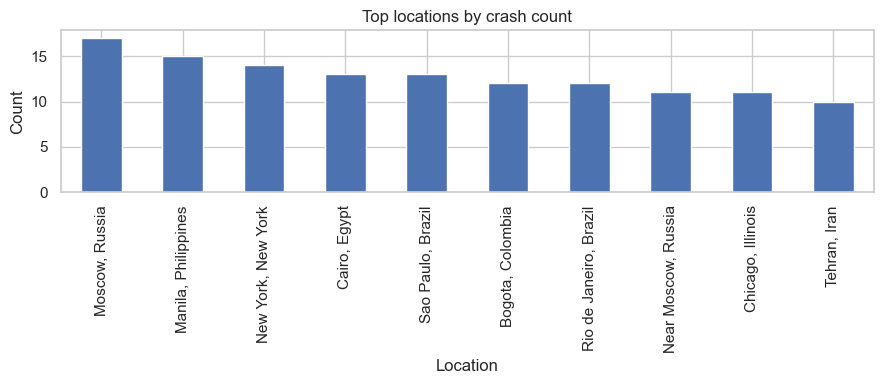

In [18]:
if COL_LOCATION is not None:
    loc_clean = df[COL_LOCATION].astype("string").str.strip()
    top_loc = loc_clean.value_counts().head(10)
    print("Top locations by crash count:")
    print(top_loc)

    plt.figure(figsize=(9,4))
    top_loc.plot(kind="bar")
    plt.title("Top locations by crash count")
    plt.xlabel("Location"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Location column not found.")


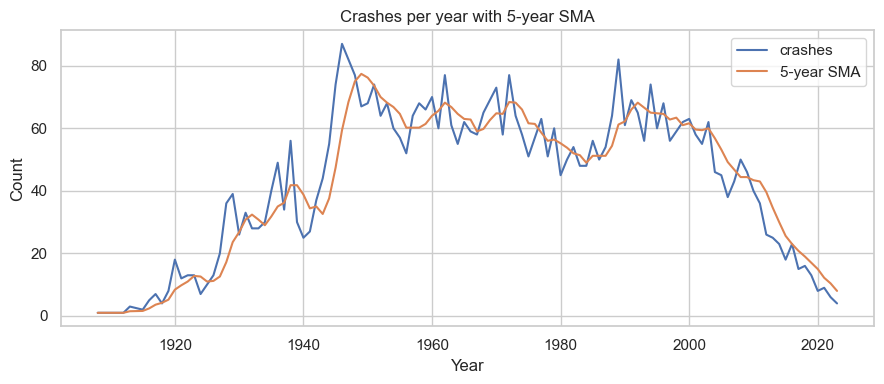

In [19]:
if "year" in df_clean.columns:
    yearly = df_clean.groupby("year").size().reset_index(name="crashes")
    yearly["sma5"] = yearly["crashes"].rolling(window=5, min_periods=1).mean()

    plt.figure(figsize=(9,4))
    plt.plot(yearly["year"], yearly["crashes"], label="crashes")
    plt.plot(yearly["year"], yearly["sma5"], label="5-year SMA")
    plt.title("Crashes per year with 5-year SMA")
    plt.xlabel("Year"); plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Year column is not available for smoothing.")


In [20]:
msgs = []
msgs.append("We cleaned the dataset, parsed dates, and converted numeric columns.")
msgs.append("We explored annual crash trends, fatalities distribution, and survival rates.")
msgs.append("We visualized crashes by year and by top locations.")
msgs.append("We tested if mean fatalities differ between two major decades (Welch t-test).")
msgs.append("Further work may include non-parametric tests and modeling with covariates.")

print("Summary:")
for m in msgs:
    print("-", m)


Summary:
- We cleaned the dataset, parsed dates, and converted numeric columns.
- We explored annual crash trends, fatalities distribution, and survival rates.
- We visualized crashes by year and by top locations.
- We tested if mean fatalities differ between two major decades (Welch t-test).
- Further work may include non-parametric tests and modeling with covariates.
